# <center> Individual Project. Predicting the rating of the drug based on the review</center>

Greetings, 

Machine learning has permeated nearly all fields and disciplines of study. One hot topic is using natural language processing and sentiment analysis to identify, extract, and make use of subjective information. The UCI ML Drug Review dataset provides patient reviews on specific drugs along with related conditions and a 10-star patient rating system reflecting overall patient satisfaction. The data was obtained by crawling online pharmaceutical review sites. 

This data was published in a study on sentiment analysis of drug experience over multiple facets, ex. sentiments learned on specific aspects such as effectiveness and side effects (see the acknowledgments section to learn more).

The dataset was originally published on the UCI Machine Learning repository: https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

Citation: 

Felix Gräßer, Surya Kallumadi, Hagen Malberg, and Sebastian Zaunseder. 2018. Aspect-Based Sentiment Analysis of Drug Reviews Applying Cross-Domain and Cross-Data Learning. In Proceedings of the 2018 International Conference on Digital Health (DH '18). ACM, New York, NY, USA, 121-125.

You can also download it easily from kagle dataset:
https://www.kaggle.com/jessicali9530/kuc-hackathon-winter-2018

To simplify the project evaluation I'll follow the proposed plan:

# Project outline
1. Feature and data explanation
2. EDA, VDA, Insights and found dependencies
3. Metrics selection 
4. Data preprocessing and model selection
5. Cross-validation and adjustment of model hyperparameters
6. Creation of new features and description of this process
7. Plotting training and validation curves
8. Prediction for test or hold-out samples 
9. Conclusions

# 1. Feature and data explanation

First, load the dataset 

In [1]:
import pandas as pd
import os
import warnings
warnings.filterwarnings('ignore')

random_state = 42

PATH_TO_DATA = 'C:/Projects/Python/ODS_ml_course/indiv_proj/'
df_train = pd.read_csv(os.path.join(PATH_TO_DATA,
                                     'drugsComTrain_raw.csv'), parse_dates=["date"])
df_test = pd.read_csv(os.path.join(PATH_TO_DATA,
                                     'drugsComTest_raw.csv'), parse_dates=["date"])
df_train.drop('uniqueID', axis=1, inplace=True)
df_test.drop('uniqueID', axis=1, inplace=True)

Let's take a look at our data

In [2]:
df_train.head()

,drugName,condition,review,rating,date,usefulCount
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,2012-05-20,27
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,2010-04-27,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,2009-12-14,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,2015-11-03,10
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,2016-11-27,37


In [3]:
df_train.shape

(161297, 6)

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 161297 entries, 0 to 161296
Data columns (total 6 columns):
drugName       161297 non-null object
condition      160398 non-null object
review         161297 non-null object
rating         161297 non-null int64
date           161297 non-null datetime64[ns]
usefulCount    161297 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 7.4+ MB


In [5]:
df_test.head()

,drugName,condition,review,rating,date,usefulCount
0,Mirtazapine,Depression,"""I&#039;ve tried a few antidepressants over th...",10,2012-02-28,22
1,Mesalamine,"Crohn's Disease, Maintenance","""My son has Crohn&#039;s disease and has done ...",8,2009-05-17,17
2,Bactrim,Urinary Tract Infection,"""Quick reduction of symptoms""",9,2017-09-29,3
3,Contrave,Weight Loss,"""Contrave combines drugs that were used for al...",9,2017-03-05,35
4,Cyclafem 1 / 35,Birth Control,"""I have been on this birth control for one cyc...",9,2015-10-22,4


In [6]:
df_test.shape

(53766, 6)

In [7]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53766 entries, 0 to 53765
Data columns (total 6 columns):
drugName       53766 non-null object
condition      53471 non-null object
review         53766 non-null object
rating         53766 non-null int64
date           53766 non-null datetime64[ns]
usefulCount    53766 non-null int64
dtypes: datetime64[ns](1), int64(2), object(3)
memory usage: 2.5+ MB


The columns included in this dataset are:

1. drugName (categorical): name of drug 
2. condition (categorical): name of condition 
3. review (text): patient review 
4. rating (numerical): 10 star patient rating 
5. date (date): date of review entry 
6. usefulCount (numerical): number of users who found review useful

The structure of the data is that a patient purchases a drug that meets his condition and writes a review and rating for the drug he/she purchased. Afterwards, if the others read that review and find it helpful, they will click usefulCount, which will add 1 for the variable.

The data is split into a train (75%) and test (25%) partition.


The initial tasks were

1. Classification: Can you predict the patient's condition based on the review?
2. Regression: Can you predict the rating of the drug based on the review?
3. Sentiment analysis: What elements of a review make it more helpful to others? Which patients tend to have more negative reviews? Can you determine if a review is positive, neutral, or negative?
4. Data visualizations: What kind of drugs are there? What sorts of conditions do these patients have?

The rating variable is ordinal. To be sure, it would be a lot of paininthea$$. Let it be sentiment classification of the reviews. 

In [8]:
df_train['target'] = df_train['rating'].apply(lambda x: 0 if x < 5 else 1 if 4 < x < 8 else 2)
df_test['target'] = df_test['rating'].apply(lambda x: 0 if x < 5 else 1 if 4 < x < 8 else 2)

df_train.drop('rating', axis=1, inplace=True)
df_test.drop('rating', axis=1, inplace=True)

# 2. EDA, VDA, Insights and found dependencies

It's time to load several libraries necessary for data analysis:

In [9]:
import re
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

First of all, as you may have noticed, there are several NaNs in the 'condition' column in both datasets.

In [10]:
df_train[pd.isnull(df_train['condition'])].head()

,drugName,condition,review,date,usefulCount,target
30,Azithromycin,NaN,"""Very good response. It is so useful for me. """,2010-08-18,1,2
148,Urea,NaN,"""Accurate information.""",2011-07-02,13,2
488,Doxepin,NaN,"""So far so good. Good for me and I can take it...",2010-10-20,25,2
733,Ethinyl estradiol / norgestimate,NaN,"""I haven&#039;t been on it for a long time and...",2011-01-24,1,2
851,Medroxyprogesterone,NaN,"""I started the shot in July 2015 and ended in ...",2017-03-23,1,1


In [11]:
df_train[pd.isnull(df_train['condition'])].shape, df_test[pd.isnull(df_test['condition'])].shape

((899, 6), (295, 6))

Well, the amount is low. And it looks like these NaNs are missing values. We'll delete them later.

Fine. Take a look at our features.

In [12]:
df_train.describe(include=['object','bool'])

,drugName,condition,review
count,161297,160398,161297
unique,3436,884,112329
top,Levonorgestrel,Birth Control,"""Good"""
freq,3657,28788,33


In [13]:
df_test.describe(include=['object','bool'])

,drugName,condition,review
count,53766,53471,53766
unique,2637,708,48280
top,Levonorgestrel,Birth Control,"""Good."""
freq,1273,9648,8


As for condition column

In [14]:
vc_condition_train = df_train['condition'].value_counts()
vc_condition_test = df_test['condition'].value_counts()

print(vc_condition_train[0:25])
print(vc_condition_test[0:25])

Birth Control                28788
Depression                    9069
Pain                          6145
Anxiety                       5904
Acne                          5588
Bipolar Disorde               4224
Insomnia                      3673
Weight Loss                   3609
Obesity                       3568
ADHD                          3383
Diabetes, Type 2              2554
Emergency Contraception       2463
High Blood Pressure           2321
Vaginal Yeast Infection       2274
Abnormal Uterine Bleeding     2096
Bowel Preparation             1859
ibromyalgia                   1791
Smoking Cessation             1780
Migraine                      1694
Anxiety and Stress            1663
Major Depressive Disorde      1607
Constipation                  1595
Panic Disorde                 1463
Chronic Pain                  1455
Migraine Prevention           1413
Name: condition, dtype: int64
Birth Control                9648
Depression                   3095
Pain                       

In [15]:
vc_condition_train[vc_condition_train < 10].shape, vc_condition_test[vc_condition_test < 10].shape

((450,), (428,))

In [16]:
vc_condition_test[0:25].index.isin(vc_condition_train[0:25].index).all()

True

Top conditions are almost the same for both datasets. More than half of the conditions occur less than 10 times.

Since condition is related to drug name 

In [17]:
conditions_drugs_train = df_train.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)
conditions_drugs_test = df_test.groupby(['condition'])['drugName'].nunique().sort_values(ascending=False)

print(conditions_drugs_train[0:25])
print(conditions_drugs_test[0:25])

condition
Not Listed / Othe                             214
Pain                                          200
Birth Control                                 172
High Blood Pressure                           140
Acne                                          117
Depression                                    105
Rheumatoid Arthritis                           98
Diabetes, Type 2                               89
Allergic Rhinitis                              88
Bipolar Disorde                                80
Osteoarthritis                                 80
Insomnia                                       78
Anxiety                                        78
Abnormal Uterine Bleeding                      74
Migraine                                       59
Psoriasis                                      58
Endometriosis                                  57
3</span> users found this comment helpful.     57
ADHD                                           55
Asthma, Maintenance                     

Top15 conditions per drugs in both datasets are the same. It is worth noting the Not Listed / Othe option, so the NaNs truly was missing. It is also should be noted the crawler errors such as '3</span> users found this comment helpful.'. We'll fix it later at preprocessing stage. 

As for drugName column

In [18]:
vc_drug_train = df_train['drugName'].value_counts()
vc_drug_test = df_test['drugName'].value_counts()

print(vc_drug_train[0:25])
print(vc_drug_test[0:25])

Levonorgestrel                        3657
Etonogestrel                          3336
Ethinyl estradiol / norethindrone     2850
Nexplanon                             2156
Ethinyl estradiol / norgestimate      2117
Ethinyl estradiol / levonorgestrel    1888
Phentermine                           1543
Sertraline                            1360
Escitalopram                          1292
Mirena                                1242
Implanon                              1102
Gabapentin                            1047
Bupropion                             1022
Venlafaxine                           1016
Miconazole                            1000
Citalopram                             995
Medroxyprogesterone                    995
Lexapro                                952
Bupropion / naltrexone                 950
Duloxetine                             934
Metronidazole                          922
Contrave                               920
Drospirenone / ethinyl estradiol       890
Depo-Prover

In [19]:
vc_drug_test[0:15].index.isin(vc_drug_train[0:15].index).all()

True

In [20]:
vc_drug_train[vc_drug_train < 10].shape, vc_drug_test[vc_drug_test < 10].shape

((2055,), (1827,))

Well, almost identically for conditions. Top15 drugs are the same. More than half of the drugs occur less than 10 times.

In [21]:
print(df_train['condition'].\
      iloc[df_train['condition'].astype(str).\
           apply(lambda str: len(str.split())).sort_values(ascending = False).index[0:10]])
print(df_train['condition'][24040:24041].apply(lambda str: len(str.split())))

24040     Deep Vein Thrombosis Prophylaxis after Knee Re...
100283    Prosthetic Heart Valves, Mechanical Valves - T...
55272     Deep Vein Thrombosis Prophylaxis after Hip Rep...
21922     Deep Vein Thrombosis Prophylaxis after Hip Rep...
101264    Prosthetic Heart Valves, Mechanical Valves - T...
9684      Prosthetic Heart Valves, Mechanical Valves - T...
34234     Deep Vein Thrombosis Prophylaxis after Knee Re...
17468     Prosthetic Heart Valves, Mechanical Valves - T...
9864      Prosthetic Heart Valves, Tissue Valves - Throm...
35966     Prosthetic Heart Valves, Tissue Valves - Throm...
Name: condition, dtype: object
24040    8
Name: condition, dtype: int64


The next part is reviews. let's look at a few

In [22]:
df_train['review'][17]

'"I&#039;ve been taking amitriptyline since January 2013 after being diagnosed with fibromyalgia. I tried cymbalta for a week and my Dr decided that since it kept me awake 24/7 that it wasn&#039;t a good fit for me even though it relieved my pain. I started with 25 mg. After 2 weeks I had some breakthrough pain, so my Dr increased my dosage to 50mg and I&#039;m still on that dosage today. For the first full year I was on this I never had pain and felt &#039;cured&#039;. As time went on, it seems to help control my pain. I do still have pain, but at a low manageable level. I take this around 7pm each evening to avoid feeling overly drowsy in the mornings. This med allows me to have a fairly normal life."'

In [23]:
df_test['review'][42]

'"I want to share my experience to possibly ease some of the ladies out there.\r\nThe incident occur in Nov 18 (the condom broke) and it was 4 days after my period ended and approximately 4 days before ovulation. This means I was fertile. \r\nwhen we noticed that the condom broke, we immediately bought Plan B One Step and was taken about 45 minutes or an hour later. \r\nThe sooner you take the greater the chances it will work.\r\nSo I waited anxiously, praying I get my period. I felt side effects such as fatigue, bloated, nauseous, cramps, and moody. I was that these might be  this pregnancy symptoms. \r\nI waited exactly two weeks and I got my period. I was the happiest person ever. My period was here early by approximately 3-4 days. Good luck."'

In [24]:
df_train['review'][100000] # what a guy

'"This medicine is terrible. In fact doctors are terrible for prescribing it. Thanks to a 15 min session of my psychiatrist nodding (while barely looking at me) then writing down a name of a pill to &quot;fix me&quot; my face has never seen such acne. He thought I was depressed before, now I don&#039;t want to even leave the house. DOCTORS OVER PRESCRIBE!!!!! Please trust me, go to your herbal neighborhood store and get things to detox from medicine. The pharmaceutical companies are making a fortune on society believing a magic pill will sustain our life and subdue our problems. You&#039;re smarter than that, right?"'

In [25]:
df_test['review'][53766 - 1] 

'"It works!!!"'

In [26]:
df_train['review'][161297 - 1] 

'"I&#039;ve had chronic constipation all my adult life. Tried Linzess, it worked for a month then stopped. Doctor started me on Amitiza (24 mg) and it is a miracle. I&#039;ve been on for four months now. After a life of 7-10 days between bowel motions, I now go comfortably 3-4 times per week. No pain, very little gas. It&#039;s a miracle for me."'

The first thing that catches the eye is '&#039' for apostrophe. Next, some formating commands such as '\r', '\n'. We'll also delete these.

The next one is usefulcount feature

In [27]:
df_train['usefulCount'].describe()

count    161297.000000
mean         28.004755
std          36.403742
min           0.000000
25%           6.000000
50%          16.000000
75%          36.000000
max        1291.000000
Name: usefulCount, dtype: float64

In [28]:
df_test['usefulCount'].describe()

count    53766.000000
mean        27.989752
std         36.172833
min          0.000000
25%          6.000000
50%         16.000000
75%         36.000000
max        949.000000
Name: usefulCount, dtype: float64

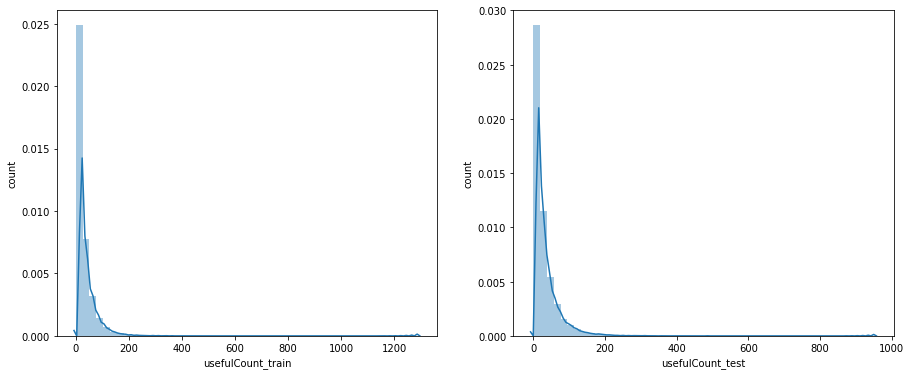

In [29]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))
sns.distplot(df_train['usefulCount'], ax=axes[0], norm_hist=True);
axes[0].set(xlabel='usefulCount_train', ylabel='count');
sns.distplot(df_test['usefulCount'], ax=axes[1], norm_hist=True);
axes[1].set(xlabel='usefulCount_test', ylabel='count');

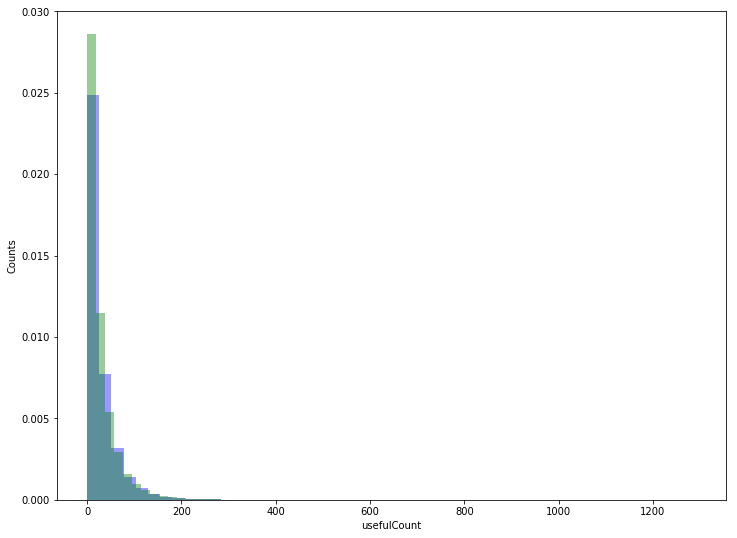

In [30]:
plt.figure(figsize=(12,9))

sns.distplot(df_train['usefulCount'], color='blue', kde=False, norm_hist=True)
sns.distplot(df_test['usefulCount'], color='green', kde=False, norm_hist=True)

plt.xlabel('usefulCount')
plt.ylabel('Counts')

plt.show()

The destributions looks like very similar for train and test datasets. 

As for the distribution itself, the problem in 'usefulCount' is that the distribution is skewed with long tails. The std is 36 when the mean is 27-28. The 'usefulCounts' is related to condition and drug. For common condition there are much more people that read the reviews and obviously much higher the 'usefulCounts'. We'll try to handle it later.

Date:

In [31]:
print(np.min(df_train['date']),np.max(df_train['date']))
print(np.min(df_test['date']),np.max(df_test['date']))

2008-02-24 00:00:00 2017-12-12 00:00:00
2008-02-25 00:00:00 2017-12-12 00:00:00


Ok. Time for target.

In [32]:
print(df_train['target'].value_counts())
print(df_train['target'].value_counts(normalize=True))

2    97410
0    40075
1    23812
Name: target, dtype: int64
2    0.603917
0    0.248455
1    0.147628
Name: target, dtype: float64


In [33]:
print(df_test['target'].value_counts())
print(df_test['target'].value_counts(normalize=True))

2    32349
0    13497
1     7920
Name: target, dtype: int64
2    0.601663
0    0.251032
1    0.147305
Name: target, dtype: float64


Classes are imbalanced.

Now it's safe to say that the test and train samples were derived from a single distribution. Let's concatenate them and continue to analyse.

In [34]:
df_all = pd.concat([df_train,df_test]).reset_index(drop=True)
mask = df_all.index < df_train.shape[0]
df_all['istrain'] = False
df_all['istrain'][mask] = True

Sorting by the time

In [35]:
df_all.sort_values(by='date',
        ascending=True).head(10)

,drugName,condition,review,date,usefulCount,target,istrain
52404,Macrobid,Bladder Infection,"""Excellent for prevention of bladder infection...",2008-02-24,52,2,True
51387,Orlistat,Obesity,"""Xenical really helped me, but some of the bow...",2008-02-24,50,1,True
67737,Oxybutynin,Not Listed / Othe,"""Improved my problem dramatically. I never exp...",2008-02-24,22,1,True
117998,Xenical,Obesity,"""Xenical really helped me, but some of the bow...",2008-02-24,50,1,True
137363,Chlorpheniramine / pseudoephedrine,Allergic Rhinitis,"""I when to a medical clinic with flu like symp...",2008-02-24,0,0,True
22355,Fentanyl,Pain,"""I don&#039;t think I could make it without th...",2008-02-25,22,2,True
184795,Flomax,Benign Prostatic Hyperplasia,"""Improved the go; no help on the flow.""",2008-02-25,66,0,False
178498,Varenicline,Smoking Cessation,"""On Chantix, I&#039;ve experienced constipatio...",2008-02-25,27,0,False
101533,Colazal,Ulcerative Colitis,"""There is new generic version of Colazal now. ...",2008-02-25,16,2,True
127277,Quetiapine,Bipolar Disorde,"""I have felt 100 % better since taking Seroque...",2008-02-25,81,2,True


Let's create the main time features

In [36]:
df_all['year'] = df_all['date'].dt.year
df_all['month'] = df_all['date'].dt.month
df_all['dom'] = df_all['date'].dt.day
df_all['dow'] = df_all['date'].dt.weekday
df_all.drop('date', axis=1, inplace=True)

In [37]:
# Graphics in SVG format are more sharp and legible
%config InlineBackend.figure_format = 'svg'

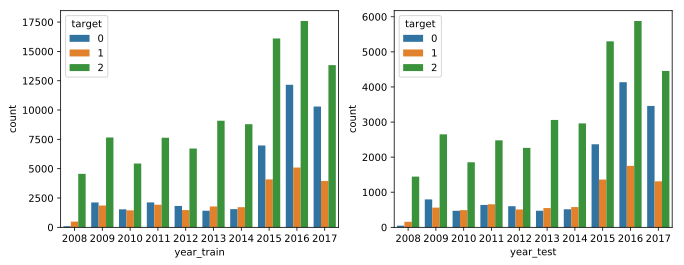

In [38]:
_, axes = plt.subplots(nrows=1, ncols=2, figsize=(11, 4))
sns.countplot(x='year', hue='target', ax=axes[0], data=df_all[df_all['istrain']]);
axes[0].set(xlabel='year_train', ylabel='count');
sns.countplot(x='year', hue='target', ax=axes[1], data=df_all[df_all['istrain'] == False]);
axes[1].set(xlabel='year_test', ylabel='count');

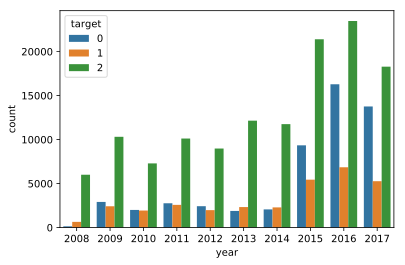

In [39]:
sns.countplot(x='year', hue='target', data=df_all);

Intresting. There can be seen 3 groups of years: 
1. 2008
2. 2009-2014
3. 2015-2017

Of particular importance is the fact that the amount of negative reviews has increased significantly from 2015. The amount of negative and neutral reviews before 2015 was almost identical.

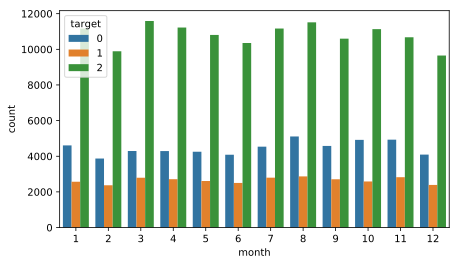

In [40]:
plt.figure(figsize=(7,4))
sns.countplot(x='month', hue='target', data=df_all);

The month would be useless

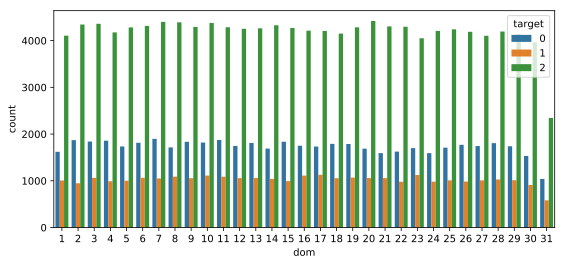

In [41]:
plt.figure(figsize=(9,4))
sns.countplot(x='dom', hue='target', data=df_all);

Nothing intresting (there are only 7 month in the year with 31 day).

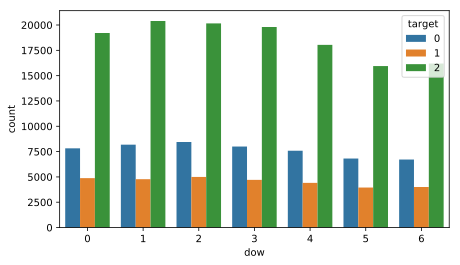

In [42]:
plt.figure(figsize=(7,4))
sns.countplot(x='dow', hue='target', data=df_all);

The same. Time features on their own (excluding year) won't help. But we'll check this out.

Back to usefulCounts

In [43]:
df_all.groupby(['target'])['usefulCount'].describe()

,count,mean,std,min,25%,50%,75%,max
target,,,,,,,,
0,53572.0,15.967483,21.142030,0.0,4.0,9.0,21.0,470.0
1,31732.0,20.298752,25.291278,0.0,4.0,12.0,27.0,346.0
2,129759.0,34.852688,41.560801,0.0,9.0,22.0,46.0,1291.0


Expected. Positive reviews often get more 'usefulCount's than negative reviews. 

In [44]:
del vc_drug_test, vc_drug_train, \
    vc_condition_train, vc_condition_test, conditions_drugs_test, conditions_drugs_train

To sum up, 
1. There are ~1300 missed values in the condition column in both datasets. We've also found crawler error in this column.
2. Datasets were derived from a single distribution, which was proved by time features, usefulCounts and the target.
3. We should bear in the mind that target classes are unbalanced when when we choose the metric and customize the model.
4. Almost all time features are useless (excluding the year). We examined 3 groups of years: 1. 2008, 2. 2009-2014, 3. 2015-2017. Of particular importance is the fact that the amount of negative reviews has increased significantly from 2015. The amount of negative and neutral reviews before 2015 was almost identical.
5. There are several things we have to correct in the reviews such as the apostrophe problem and formatting commands.
6. The usefulCount feature looks useful. But there is the problem with amount of people, which need some 'drugname' in one condition or another.

# 3. Data preprocessing,  metric and model selection

Let's start with condition since this column has missing values.

In [45]:
df_all[pd.isnull(df_all['condition'])].head(10)

,drugName,condition,review,usefulCount,target,istrain,year,month,dom,dow
30,Azithromycin,NaN,"""Very good response. It is so useful for me. """,1,2,True,2010,8,18,2
148,Urea,NaN,"""Accurate information.""",13,2,True,2011,7,2,5
488,Doxepin,NaN,"""So far so good. Good for me and I can take it...",25,2,True,2010,10,20,2
733,Ethinyl estradiol / norgestimate,NaN,"""I haven&#039;t been on it for a long time and...",1,2,True,2011,1,24,0
851,Medroxyprogesterone,NaN,"""I started the shot in July 2015 and ended in ...",1,1,True,2017,3,23,3
1014,Acetaminophen / caffeine,NaN,"""I get migraine and have found out by taking e...",7,2,True,2012,2,19,6
1124,Tavaborole,NaN,"""I have struggled with nail for 8 or ten years...",6,2,True,2016,5,21,5
1163,Acetaminophen / butalbital / caffeine / codeine,NaN,"""I found that while this medicine does relieve...",3,1,True,2011,12,11,6
1253,Ethinyl estradiol / norethindrone,NaN,"""I started Loestrin and within two months I ex...",0,0,True,2011,4,28,3
1267,Conjugated estrogens,NaN,"""I had to have a total hysterectomy in 2009 in...",27,2,True,2016,6,11,5


In [46]:
print(pd.isnull(df_all['condition']).sum())

1194


As you remember, there is an 'Not Listed / Othe' condition. 

In [47]:
print(df_all[df_all['condition'] == 'Not Listed / Othe'].shape)
df_all[df_all['condition'] == 'Not Listed / Othe'].head(10)

(592, 10)


,drugName,condition,review,usefulCount,target,istrain,year,month,dom,dow
711,Clindamycin,Not Listed / Othe,"""Just an FYI to all on this medication. Diarrh...",5,2,True,2013,11,2,5
1530,Lorazepam,Not Listed / Othe,"""For severe panic attacks, the only medication...",8,1,True,2008,8,30,5
1538,Azithromycin,Not Listed / Othe,"""My son has IGA deficiency and as soon as he s...",1,1,True,2009,2,20,4
2023,Oxycodone,Not Listed / Othe,"""I have taken this medication for severe pain ...",1,2,True,2009,2,9,0
2227,Phentermine,Not Listed / Othe,"""After I stopped smoking (appetite has increas...",1,1,True,2009,11,6,4
2519,Phentermine,Not Listed / Othe,"""I am 28. I lost 16 pounds my first 30 days. G...",2,2,True,2008,8,13,2
2717,Diazepam,Not Listed / Othe,"""I have used Valium for many years and it is s...",5,2,True,2008,11,22,5
2954,Alprazolam,Not Listed / Othe,"""Very helpful in falling and staying asleep.""",2,2,True,2012,1,28,5
3486,Alfuzosin,Not Listed / Othe,"""Nine weeks of radiation for prostate cancer a...",1,2,True,2014,9,23,1
4515,Amphetamine / dextroamphetamine,Not Listed / Othe,"""It really helps me to get rid of my symptoms ...",1,2,True,2008,12,5,4


There are also some crawler errors in condition column:

In [48]:
df_all['condition'].value_counts().tail(20)

Secondary Cutaneous Bacterial Infections        1
Short Stature                                   1
Scleroderma                                     1
Somat                                           1
Postpartum Breast Pain                          1
AV Heart Block                                  1
Rabies Prophylaxis                              1
Dermatitis Herpeti                              1
Mumps Prophylaxis                               1
Asystole                                        1
Uveitis, Posteri                                1
110</span> users found this comment helpful.    1
40</span> users found this comment helpful.     1
Ramsay Hunt Syndrome                            1
94</span> users found this comment helpful.     1
Sepsis                                          1
ungal Pneumonia                                 1
54</span> users found this comment helpful.     1
Pertussis Prophylaxis                           1
Portal Hypertension                             1


'users found this comment helpful.' -- let's count the amount of such errors with regular expressions.

In [49]:
import re

df_all['condition'].str.contains(re.compile('users found this comment helpful')).sum()

1171

Well, the amount of errors\missing values in the condition column is quiet small. And, according to the reviews, it can be seen that these people have different conditions. It's better to delete them all.

In [50]:
mask = (pd.isnull(df_all['condition'])) | (df_all['condition'] == 'Not Listed / Othe') |\
                 (df_all['condition'].str.contains(re.compile('users found this comment helpful')))

In [51]:
mask.sum()

2957

In [52]:
df_all.shape

(215063, 10)

In [53]:
df_all = df_all.drop(df_all[mask].index).reset_index(drop=True)

In [54]:
df_all.shape

(212106, 10)

For condition feature we'll apply CountVectorizer, which can by default do all the nessesary staff such as lowercased strings, excluding punctuation marks and ')(/', etc. All we have to know the number of words in the longest 'condition' for choosing the ngram range.

In [55]:
print('The number of words in the longest condition:', df_all['condition'].astype(str).\
      apply(lambda str: len(str.split())).sort_values(ascending = False).iloc[0])
print(df_all['condition'].iloc[df_all['condition'].astype(str).\
                               apply(lambda str: len(str.split())).sort_values(ascending = False).index[0]])

The number of words in the longest condition: 8
Deep Vein Thrombosis Prophylaxis after Hip Replacement Surgery


drugName. Let's one more time take a look at the values.

In [56]:
df_all['drugName'].head(15)

0                              Valsartan
1                             Guanfacine
2                                 Lybrel
3                             Ortho Evra
4               Buprenorphine / naloxone
5                                 Cialis
6                         Levonorgestrel
7                           Aripiprazole
8                                 Keppra
9     Ethinyl estradiol / levonorgestrel
10                            Topiramate
11                        L-methylfolate
12                               Pentasa
13                      Dextromethorphan
14                             Nexplanon
Name: drugName, dtype: object

In [57]:
df_all['drugName'].tail(15)

212091                     Chantix
212092    Sofosbuvir / velpatasvir
212093                      BuSpar
212094                  Lorcaserin
212095               Levetiracetam
212096           Dextroamphetamine
212097                Levofloxacin
212098                 Armodafinil
212099       Microgestin Fe 1 / 20
212100                        Apri
212101                   Tamoxifen
212102                Escitalopram
212103              Levonorgestrel
212104                  Tapentadol
212105                   Arthrotec
Name: drugName, dtype: object

As for condition, let's find the longest drug name.

In [58]:
print(df_all['drugName'].iloc[df_all['drugName'].astype(str).\
                               apply(lambda str: len(str.split())).sort_values(ascending = False).index[1]])
print(df_all['drugName'].iloc[df_all['drugName'].astype(str).\
                               apply(lambda str: len(str.split())).sort_values(ascending = False).index[4]])

Bisacodyl / polyethylene glycol 3350 / potassium chloride / sodium bicarbonate / sodium chloride
Hyoscyamine / methenamine / methylene blue / phenyl salicylate / sodium biphosphate


Ok, max ngram range would be 10.

Time for reviews.

Let's create WordClouds.

In [59]:
# !pip isntall WordCloud
# !conda install -c conda-forge wordcloud 
from wordcloud import WordCloud, STOPWORDS

def plot_wordcloud(data, title):
    wordcloud = WordCloud(background_color='black', stopwords = STOPWORDS, max_words = 100, max_font_size = 100, 
                    random_state = 42, width=1280, height=720)
    wordcloud.generate(str(data))
    
    plt.figure(figsize=(9, 6))

    plt.imshow(wordcloud, interpolation="bilinear");

    plt.title(title, fontdict={'size': 20, 'color': 'black', 
                                  'verticalalignment': 'bottom'})
    
    plt.axis('off')
    plt.tight_layout()  

In computing, stop words are words which are filtered out before or after processing of natural language data (text). Though "stop words" usually refers to the most common words in a language, there is no single universal list of stop words used by all natural language processing tools, and indeed not all tools even use such a list. Some tools specifically avoid removing these stop words to support phrase search. 
Citation: https://en.wikipedia.org/wiki/Stop_words

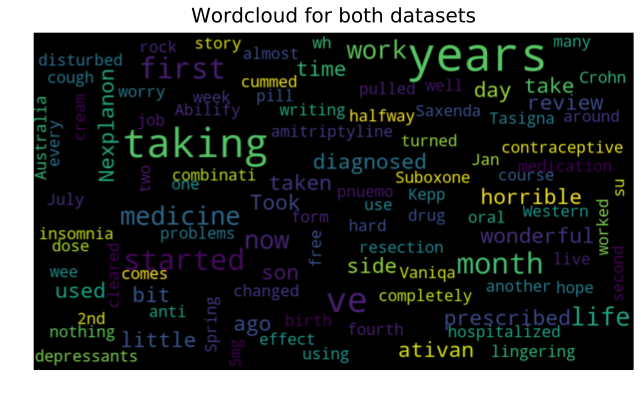

In [60]:
plot_wordcloud(df_all['review'], 'Wordcloud for both datasets')

Let's group_by reviews by the target

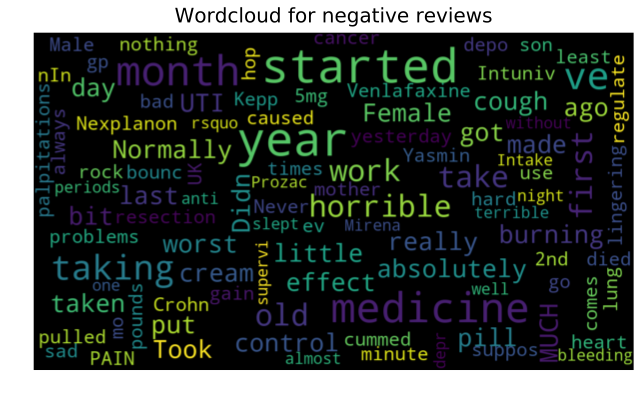

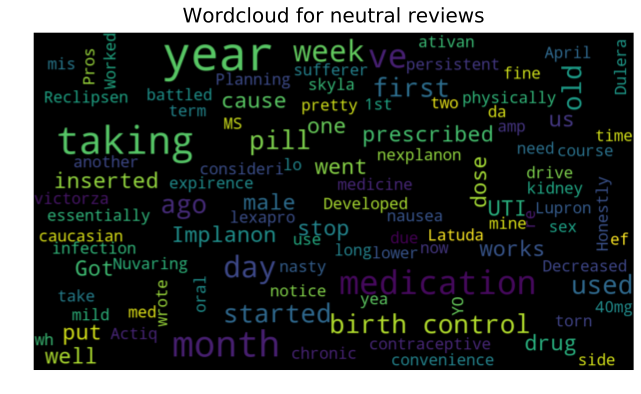

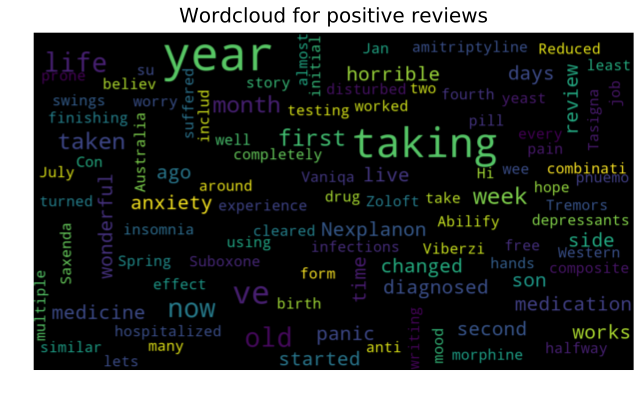

In [61]:
plot_wordcloud(df_all['review'][df_all['target'] == 0], 'Wordcloud for negative reviews')
plot_wordcloud(df_all['review'][df_all['target'] == 1], 'Wordcloud for neutral reviews')
plot_wordcloud(df_all['review'][df_all['target'] == 2], 'Wordcloud for positive reviews')

Well, it looks like single words won't help us much. Just several words such as horrible, terrible. 

Can you see the difference?

As we remember, there are problem with apostrophes. We'll replace them with space symbol

In [62]:
df_all['review'] = df_all['review'].str.replace('&#039;', " ", regex=False);

In [63]:
df_all['review'][17]

'"I ve been taking amitriptyline since January 2013 after being diagnosed with fibromyalgia. I tried cymbalta for a week and my Dr decided that since it kept me awake 24/7 that it wasn t a good fit for me even though it relieved my pain. I started with 25 mg. After 2 weeks I had some breakthrough pain, so my Dr increased my dosage to 50mg and I m still on that dosage today. For the first full year I was on this I never had pain and felt  cured . As time went on, it seems to help control my pain. I do still have pain, but at a low manageable level. I take this around 7pm each evening to avoid feeling overly drowsy in the mornings. This med allows me to have a fairly normal life."'

Fine. We'll use TfidfVectorizer for reviews with stopwords. We'll try 3 ngram_ranges: (1,1), (1,3), (2,3). 

As for time feature, we'll first include all of them with propper transformation (ohe for years; sin_cos trasnform for days_of_week, days_of_month, month)

In [64]:
def add_time_features(df):
    df['dow_sin'] = df['dow'].apply(lambda ts: np.sin(2*np.pi*ts/7.))
    df['dow_cos'] = df['dow'].apply(lambda ts: np.cos(2*np.pi*ts/7.))
    
    df['dom_sin'] = df['dom'].apply(lambda ts: np.sin(2*np.pi*ts/31.))
    df['dom_cos'] = df['dom'].apply(lambda ts: np.cos(2*np.pi*ts/31.))
    
    df['month_sin'] = df['month'].apply(lambda ts: np.sin(2*np.pi*ts/12.))
    df['month_cos'] = df['month'].apply(lambda ts: np.cos(2*np.pi*ts/12.))

    df.drop(['month', 'dom', 'dow'], axis=1, inplace=True)

    return df

In [65]:
df_all = add_time_features(df_all)
df_all.head()

,drugName,condition,review,usefulCount,target,istrain,year,dow_sin,dow_cos,dom_sin,dom_cos,month_sin,month_cos
0,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",27,2,True,2012,-0.781831,0.62349,-0.790776,-0.612106,5.000000e-01,-0.866025
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",192,2,True,2010,0.781831,0.62349,-0.724793,0.688967,8.660254e-01,-0.500000
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",17,1,True,2009,0.000000,1.00000,0.299363,-0.954139,-2.449294e-16,1.000000
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",10,2,True,2015,0.781831,0.62349,0.571268,0.820763,-5.000000e-01,0.866025
4,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",37,2,True,2016,-0.781831,0.62349,-0.724793,0.688967,-5.000000e-01,0.866025


Initially, we'll just scale 'usefulCount' with StandardScaler 

Model selection.

Taking into account 
1. the size of the task (the amount of features after preprocessing -- a waste of time using RandomForestClassifier, GBM, etc)
2. the size of the corpus of the reviews (~160k reviews in the train dataset)
3. the presense of numerical features (can't simply use something like NaiveBayesClassifier)
4. possibilities of the laptop (sad)
5. instructions not to dive deep (NN, specific methods for specific tasks, which sentimental analysis is)

I decided to work with multinomial logistic regression. We worked with it several times. I think there's no need to describe the pros and cons one more time.

Metric selection.

Well, since there is multinomial classification + imbalanced classes:

0. negative -- 0.251032
1. neutral -- 0.147305
2. positive -- 0.601663

So, simple accuracy isn't good idea. In this case better choose precision\recall or even 'weighted' F1-score. Here's the description from sklearn documentation https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html#sklearn.metrics.accuracy_score 
'weighted':
Calculate metrics for each label, and find their average weighted by support (the number of true instances for each label). 


Ok. Let's continue

In [66]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, precision_score, recall_score

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV

class LemmaTokenizer(object):
    def __init__(self):
        self.wnl = WordNetLemmatizer()
    def __call__(self, doc):
        return [self.wnl.lemmatize(t) for t in word_tokenize(doc)]

In [67]:
X_train = df_all[df_all['istrain']]
X_test = df_all[df_all['istrain'] == False]
y_train = df_all['target'][df_all['istrain']]
y_test = df_all['target'][df_all['istrain'] == False]

X_train.drop(['istrain','target'], axis=1, inplace=True)
X_test.drop(['istrain','target'], axis=1, inplace=True)

Pipeline. Time is running out, deadline is close, so this is the best working variant I can do for now :)

In [68]:
class TextSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

class NumberSelector(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
        
uc_transformer =  Pipeline(steps = [
                ('selector_uc', NumberSelector(key = 'usefulCount')),
                ('scaler_uc', StandardScaler())
            ])

dow_sin_transformer =  Pipeline(steps = [
                ('selector_dow_sin', NumberSelector(key = 'dow_sin')),
                ('scaler_dow_sin', StandardScaler())
            ])
dow_cos_transformer =  Pipeline(steps = [
                ('selector_dow_cos', NumberSelector(key = 'dow_cos')),
                ('scaler_dow_cos', StandardScaler())
            ])

dom_sin_transformer =  Pipeline(steps = [
                ('selector_dom_sin', NumberSelector(key = 'dom_sin')),
                ('scaler_dom_csin', StandardScaler())
            ])
dom_cos_transformer =  Pipeline(steps = [
                ('selector_dom_cos', NumberSelector(key = 'dom_cos')),
                ('scaler_dom_cos', StandardScaler())
            ])

month_sin_transformer =  Pipeline(steps = [
                ('selector_month_sin', NumberSelector(key = 'month_sin')),
                ('scaler_month_sin', StandardScaler())
            ])
month_cos_transformer =  Pipeline(steps = [
                ('selector_month_cos', NumberSelector(key = 'month_cos')),
                ('scaler_month_cos', StandardScaler())
            ])

cond_tranformer = Pipeline(steps = [
                ('selector_cond', TextSelector(key='condition')),
                ('cv_cond', CountVectorizer(stop_words='english', ngram_range=(1,8)))
            ])

drug_tranformer = Pipeline(steps = [
                ('selector_drug', TextSelector(key='drugName')),
                ('cv_cond', CountVectorizer(stop_words='english', ngram_range=(1,10)))
            ])

y_transformer = Pipeline(steps = [
                ('selector_y', NumberSelector(key='year')),
                ('ohe_y', OneHotEncoder(handle_unknown='ignore'))
            ])

rev_tranformer = Pipeline(steps = [
                ('selector_rev', TextSelector(key='review')),
                ('tfidf_rev',TfidfVectorizer(stop_words='english', 
                                             ngram_range=(1,3),
                                             max_features = 100000
                                            )
                )
            ])

preprocessor = FeatureUnion([
        ('usefulCount', uc_transformer),
        ('dow_sin', dow_sin_transformer), 
        ('dow_cos', dow_cos_transformer), 
        ('dom_sin', dom_sin_transformer), 
        ('dom_cos', dom_sin_transformer), 
        ('month_sin', month_sin_transformer), 
        ('month_cos', month_cos_transformer), 
        ('condition', cond_tranformer),
        ('drugName', drug_tranformer),
        ('year', y_transformer),
        ('review', rev_tranformer)
    ])


mlog = Pipeline(steps = [('preprocessor', preprocessor),
                         ('logreg', LogisticRegression(random_state=42, solver = 'lbfgs', multi_class='multinomial'))])


Let's try to predict

In [69]:
%%time

warnings.filterwarnings('ignore')

mlog.fit(X_train,  y_train)

Wall time: 1min 36s


Weighted f1 score for test dataset

In [70]:
y_pred = mlog.predict(X_test)
print('Weighted f1 score for test dataset',f1_score(y_test, y_pred, average='weighted'))

Weighted f1 score for test dataset 0.7352583402819284


Let's also compute accuracy

In [71]:
print('Accuracy score', accuracy_score(y_test, y_pred))

Accuracy score 0.7616264821761833


And confusion_matrix: https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py

In [72]:
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Confusion matrix, without normalization
[[ 9674   741  2918]
 [ 2098  1439  4262]
 [ 1804   822 29289]]


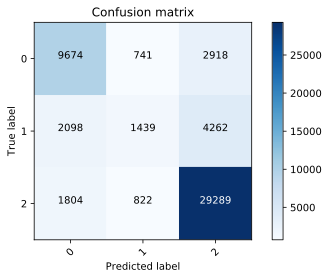

In [73]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred),classes = [0, 1, 2])

Well, i suppose for default model it's ok. Time for CV

# 4. Creation of new features and description of this process


Ok, now we'll try to drop features that might have no impact. As was stated, all time features except year should be removed. Moreover, instead of the year column we will create 3 bool features for 3 groups described above.

We also need to handle the problem with usefulCounts. The simple idea is to devide by the amount of conditions

In [74]:
def add_new_features(df):
    df['year1'] = df['year'] == 2008
    df['year2'] = (df['year'] < 2015) & (df['year'] > 2008)
    df['year3'] = (2014 < df['year']) & (df['year'] < 2018)

    df.drop('year', axis=1, inplace=True)

    return df

df_all.drop(['dow_sin', 'dow_cos', 'dom_sin', 'dom_cos', 'month_sin', 'month_cos'], axis = 1, inplace = True)
df_all = add_new_features(df_all)

In [75]:
X_train = df_all[df_all['istrain']]
X_test = df_all[df_all['istrain'] == False]
y_train = df_all['target'][df_all['istrain']]
y_test = df_all['target'][df_all['istrain'] == False]

X_train.drop(['istrain','target'], axis=1, inplace=True)
X_test.drop(['istrain','target'], axis=1, inplace=True)

In [76]:
y1_transformer = Pipeline(steps = [
                ('selector_y1', NumberSelector(key='year1'))
            ])

y2_transformer = Pipeline(steps = [
                ('selector_y2', NumberSelector(key='year2'))
            ])

y3_transformer = Pipeline(steps = [
                ('selector_y3', NumberSelector(key='year3'))
            ])

preprocessor2 = FeatureUnion([
        ('usefulCount', uc_transformer),
        ('condition', cond_tranformer),
        ('drugName', drug_tranformer),
        ('year1', y1_transformer),
        ('year2', y2_transformer),
        ('year3', y3_transformer),
        ('review', rev_tranformer)
    ])


mlog2 = Pipeline(steps = [('preprocessor', preprocessor2),
                         ('logreg', LogisticRegression(random_state=42, solver = 'lbfgs', multi_class='multinomial', ))])


Let's check this out

In [77]:
%%time
mlog2.fit(X_train,  y_train)

Wall time: 1min 45s


Pipeline(memory=None,
     steps=[('preprocessor', FeatureUnion(n_jobs=None,
       transformer_list=[('usefulCount', Pipeline(memory=None,
     steps=[('selector_uc', NumberSelector(key='usefulCount')), ('scaler_uc', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('condition', Pipeline(memory=None,
     steps=... penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))])

In [78]:
y_pred2 = mlog2.predict(X_test)
print('Weighted f1 score for test dataset',f1_score(y_test, y_pred2, average='weighted'))

Weighted f1 score for test dataset 0.7446985108790461


In [79]:
print('Accuracy score', accuracy_score(y_test, y_pred2))

Accuracy score 0.7668294154240579


Well, despite the imbalanced classes, accuracy looks fine.

Confusion matrix, without normalization
[[ 9811   851  2671]
 [ 2053  1698  4048]
 [ 1745  1001 29169]]


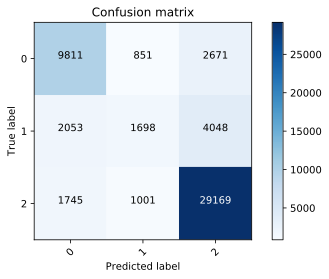

In [80]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred2),classes = [0, 1, 2])

Well, looks better!

# 5. Cross-validation and adjustment of model hyperparameters


Since our classes imbalancedand the train\test came from the same distribution, we'll perform StratifiedKFold with 3 splits

In [89]:
from sklearn.model_selection import StratifiedKFold

In [90]:
cv = StratifiedKFold(n_splits = 3)

Time for tuning hyperparameters. 

Logreg, if you remember, has two methods for regularization: l1, l2 regularization. But there are only 3 solvers which support multiclass problems and all of them works only with l2. I think, there's no need to describe what is l2 regularization.

As for Tfidf, as was stated above, we'll try several ngram_ranges. Let the max amount of features stay constant (100k)

In [91]:
param_grid = {
    'preprocessor__review__tfidf_rev__ngram_range': [(1,1), (1,3), (2,3)],
    'logreg__C': [0.1, 0.5, 1.0, 2],
}

grid_search = GridSearchCV(mlog2, param_grid, cv=cv, scoring = 'f1_weighted',verbose = 20, n_jobs = -1)

In [92]:
grid_search.fit(X_train,y_train)

Fitting 3 folds for each of 12 candidates, totalling 36 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  4.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  4.8min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  6.1min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  6.2min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  6.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  7.3min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  9.4min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  9.6min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed: 10

GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=False),
       error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('preprocessor', FeatureUnion(n_jobs=None,
       transformer_list=[('usefulCount', Pipeline(memory=None,
     steps=[('selector_uc', NumberSelector(key='usefulCount')), ('scaler_uc', StandardScaler(copy=True, with_mean=True, with_std=True))])), ('condition', Pipeline(memory=None,
     steps=... penalty='l2', random_state=42, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'preprocessor__review__tfidf_rev__ngram_range': [(1, 1), (1, 3), (2, 3)], 'logreg__C': [0.1, 0.5, 1.0, 2]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='f1_weighted', verbose=20)

In [93]:
print('grid search params:', grid_search.best_params_)
print('grid search score:', grid_search.best_score_)

grid search params: {'logreg__C': 2, 'preprocessor__review__tfidf_rev__ngram_range': (1, 3)}
grid search score: 0.7458975135765514


# 6. Plotting training and validation curves


No time for this biblethumpbiblethumpbiblethump

# 7. Prediction for test or hold-out samples 


Deadline is over but I stack here: mlog2.set_params(grid_search.best_params_) isn't working...

In [104]:
mlog2.set_params(logreg__C = 2, preprocessor__review__tfidf_rev__ngram_range = (1, 3))
mlog2.fit(X_train, y_train)
y_pred_final = mlog2.predict(X_test)

In [105]:
print('Weighted f1 score for test dataset', f1_score(y_test, y_pred_final, average='weighted'))

Weighted f1 score for test dataset 0.7426944055610862


In [107]:
print('Accuracy score', accuracy_score(y_test, y_pred_final))

Accuracy score 0.766131920749524


Score decreased. Well, nothing left to do. Better CV (more splits, more params values) should improve the results, because the are derived from the same distribution.

# 8. Conclusions


In this project we consider the sentimental classification problem based on the UCI ML Drug Review dataset. We tryed to apply as much as possible of what we have learned for last 3 month. Nevertheless, the results are shown. Not so good, but... c'mon, it's just a begining. Simple pipeline with a lil bit feauture engineering gave us the above result. As stated in the evaluation criteria I've to describe the value of the project. Well, for me it's huge. Filling out the forms is no match for your own project. I hope you share my opinion.

Possible cases of application? No one. But as a baseline for me to learn something about sentimental analysis is fine.

And, of course, there are a lot of ways to improving: NLP tecniques, deep learning, etc. But first of all I have to finnish the task.

Thanks for reading!
